## Build a classification model for Survival.csv dataset
Find dataset describtion here
https://physionet.org/content/challenge-2012/1.0.0/


In [1]:
# Create a table to compere all classification models LR, LDA, QDA, DT, NB, SVM, Ansamble models
# Save the model in pickle format.
# Create predict.py file which will load the model and predict on the test.csv file
# Your code should be able to run from the command line having test argument
# And should save the predictions.npy which are the probabilities of the class being true.
# Ex. python predict.py --test test.csv 

In [2]:
import pandas as pd
import numpy as np
survival = pd.read_csv("Survival_dataset.csv")

In [3]:
from sklearn.model_selection import train_test_split

X = survival[survival.columns.difference(["In-hospital_death"])]
y = survival['In-hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
train = pd.concat([X_train, y_train], axis=1)

In [5]:
X_test = X_test.drop(['Survival', 'Length_of_stay'], axis=1)
X_test.reset_index(drop=True, inplace=True)
X_test.to_csv('test.csv', index=False)
y_test.reset_index(drop=True, inplace=True)

In [6]:
# drop the columns with more than 60% NAs
moreThan = []
for feature in train:
    if train[feature].isna().sum() / train.shape[0] > 0.6:
        moreThan.append(feature)
train.drop(moreThan, axis=1, inplace=True)

In [7]:
# drop the rows with more than 40% NAs
drop_index = []
for i in range(len(train)):
    if train.loc[i].isna().sum() / train.shape[1] > 0.4:
        drop_index.append(i)
train.drop(index=drop_index, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

In [8]:
# drop meaningless or redundant features
NISysABP = ['NISysABP_first', 'NISysABP_last', 'NISysABP_lowest', 'NISysABP_highest', 'NISysABP_median']
NIDiasABP = ['NIDiasABP_first', 'NIDiasABP_last', 'NIDiasABP_lowest', 'NIDiasABP_highest', 'NIDiasABP_median']
NIMAP = ['NIMAP_first', 'NIMAP_last', 'NIMAP_lowest', 'NIMAP_highest', 'NIMAP_median']

train.drop(NIMAP, axis=1, inplace=True)
train.drop(NISysABP, axis=1, inplace=True) 
train.drop(NIDiasABP, axis=1, inplace=True) 

train.drop(['recordid', 'MechVentStartTime'], axis=1, inplace=True)

In [9]:
# BUN/Creatinine
train['BUN/Creatinine_first'] = train.BUN_first / train.Creatinine_first
train['BUN/Creatinine_last'] = train.BUN_last / train.Creatinine_last
# train = train.drop(['BUN_first', 'BUN_last', 'Creatinine_first', 'Creatinine_last'], axis=1)

In [10]:
# drop the observations representing people higher than 272 sm 
drop_height = []
for i in range(len(train)):
    if not np.isnan(train.loc[i]['Height']) and train.loc[i]['Height'] > 220:
        drop_height.append(i)
train.drop(index=drop_height, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

In [11]:
# replace -1 values with NAN in 'SAPS-I' and 'SOFA' features
train['SAPS-I'] = train['SAPS-I'].map(lambda v: np.nan if v == -1 else v)
train['SOFA'] = train['SOFA'].map(lambda v: np.nan if v == -1 else v)

In [12]:
train.Glucose_first = train.Glucose_first.map(lambda v: 4 if v >= 300 else (3 if v <= 15 else (2 if v <= 40 else 1)))
train.Glucose_last = train.Glucose_last.map(lambda v: 4 if v >= 300 else (3 if v <= 15 else (2 if v <= 40 else 1)))
# train = train.drop(['Glucose_lowest', 'Glucose_highest', 'Glucose_median'], axis=1)

In [13]:
train.HR_first = train.HR_first.map(lambda v: 1 if 60 <= v <= 100 else(2 if v < 60 else 3))
train.HR_last = train.HR_last.map(lambda v: 1 if 60 <= v <= 100 else(2 if v < 60 else 3))
# train = train.drop(['HR_highest', 'HR_lowest', 'HR_median'], axis=1)

In [14]:
train['PaO2/FiO2_first'] = train.PaO2_first / train.FiO2_first
train['PaO2/FiO2_last'] = train.PaO2_last / train.FiO2_last
train['PaCO2/FiO2_first'] = train.PaCO2_first / train.FiO2_first
train['PaCO2/FiO2_last'] = train.PaCO2_last / train.FiO2_last
# train = train.drop(['PaO2_first', 'PaO2_last', 'PaCO2_last', 'PaCO2_last', 'FiO2_first', 'FiO2_last'], axis=1)

In [15]:
import pickle
min_max_dict = dict()
for feature in train.columns.difference(['In-hospital_death']):
    df = train[feature][train[feature].notna()]
    min_max_dict[feature] = df.min(), df.max()
    train[feature] = train[feature].map(lambda v: (v-df.min())/(df.max()-df.min()))

fileObj = open('min_max.obj', 'wb')
pickle.dump(min_max_dict, fileObj)
fileObj.close()

In [16]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
imputer.fit(train) 

train = pd.DataFrame(data=imputer.transform(train), columns=train.columns)

In [17]:
X_train = train[train.columns.difference(['In-hospital_death', 'Survival', 'Length_of_stay'])]
X_train.sort_index(axis=1, inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_train.to_csv('X_train.csv', index=False)

y_train = train['In-hospital_death']
y_train.reset_index(drop=True, inplace=True)

In [18]:
from sklearn.utils import resample

df_majority = train[train['In-hospital_death'] == 0]
df_minority = train[train['In-hospital_death'] == 1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority class
train = pd.concat([df_majority, df_minority_upsampled])
# Display new class counts
train['In-hospital_death'].value_counts()

1.0    2936
0.0    2936
Name: In-hospital_death, dtype: int64

In [19]:
X_train_upsampled = train[train.columns.difference(['In-hospital_death', 'Survival', 'Length_of_stay'])]
X_train_upsampled.reset_index(drop=True, inplace=True)
X_train_upsampled.sort_index(axis=1, inplace=True)

y_train_upsampled = train['In-hospital_death']
y_train_upsampled.reset_index(drop=True, inplace=True)

In [20]:
test = pd.read_csv('test.csv')
test_length = test.shape[0]

In [21]:
test['BUN/Creatinine_first'] = test.BUN_first / test.Creatinine_first
test['BUN/Creatinine_last'] = test.BUN_last / test.Creatinine_last

test['SAPS-I'] = test['SAPS-I'].map(lambda v: np.nan if v == -1 else v)
test['SOFA'] = test['SOFA'].map(lambda v: np.nan if v == -1 else v)

test.Glucose_first = test.Glucose_first.map(lambda v: 4 if v >= 300 else (3 if v <= 15 else (2 if v <= 40 else 1)))
test.Glucose_last = test.Glucose_last.map(lambda v: 4 if v >= 300 else (3 if v <= 15 else (2 if v <= 40 else 1)))

test.HR_first = test.HR_first.map(lambda v: 1 if 60 <= v <= 100 else(2 if v < 60 else 3))
test.HR_last = test.HR_last.map(lambda v: 1 if 60 <= v <= 100 else(2 if v < 60 else 3))

test['PaO2/FiO2_first'] = test.PaO2_first / test.FiO2_first
test['PaO2/FiO2_last'] = test.PaO2_last / test.FiO2_last
test['PaCO2/FiO2_first'] = test.PaCO2_first / test.FiO2_first
test['PaCO2/FiO2_last'] = test.PaCO2_last / test.FiO2_last

useless = []
for feature in test:
    if feature not in X_train.columns:
        useless.append(feature)
test.drop(useless, axis=1, inplace=True)   
test.sort_index(axis=1, inplace=True)

In [22]:
fileObj = open('min_max.obj', 'rb')
min_max_dict = pickle.load(fileObj)
fileObj.close()

for feature in test:
    test[feature] = test[feature].map(lambda v: (v-min_max_dict[feature][0])/(min_max_dict[feature][1]-min_max_dict[feature][0]))

In [23]:
temp = pd.concat([X_train, test])

In [24]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
imputer.fit(temp) 

temp = pd.DataFrame(data=imputer.transform(temp), columns=temp.columns)

In [25]:
X_test = temp.tail(test_length)
X_test.reset_index(drop=True, inplace=True)

### Start the training of the models from here. 
### Now we have X_train, y_train, X_train_upsampled, y_train_upsampled,  X_test,  and y_test

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gnnk9wit because the default path (/home/gevorg/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


accuracy: 0.9
mcc: 0.5328584003487588
precision: 0.78125
recall: 0.43103448275862066
f1_score: 0.5555555555555556
auc_precision_recall:  0.5776408805570155


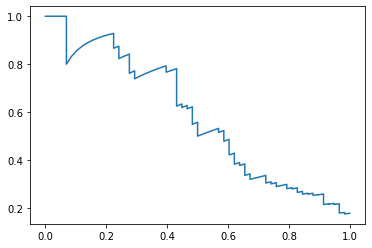

In [26]:
from sklearn.metrics import matthews_corrcoef, accuracy_score, average_precision_score, precision_recall_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train, eval_metric='logloss')

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, predictions)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, predictions)
print('mcc:', mcc)

precision1 = precision_score(y_test, predictions)
print('precision:', precision1)

recall1 = recall_score(y_test, predictions)
print('recall:', recall1)

f1 = f1_score(y_test, predictions)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df = pd.DataFrame(metrics, index=['XGBoost'], 
                  columns=['accuracy', 'mcc', 'precision', 'recall', 'f1', 'auc_precision_recall', 'Upsampled'])

plt.plot(recall, precision)
plt.show()

In [27]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import KFold

# model = GradientBoostingClassifier()

# kfold = KFold(n_splits=3, shuffle=True, random_state=0)

# distributions = dict(loss = ['deviance', 'exponential'], 
#                      learning_rate = list(np.arange(0.02, 2, 0.02)), 
#                      n_estimators = list(range(100, 5000, 200)), 
#                      subsample = list(np.round(np.arange(0.2, 1.2, 0.2), 2)), 
#                      criterion = ['friedman_mse', 'mse', 'mae'],
#                      max_features = ['auto', 'sqrt', 'log2', None], 
#                      max_depth = [2, 3, 4, 5])

# rscv = RandomizedSearchCV(estimator=model, param_distributions=distributions, 
#                           cv=kfold, scoring='f1', n_jobs=-1, random_state=0)

# best_score = 0
# best_params = None
# for _ in range(10):
#     search = rscv.fit(X_train, y_train)
#     if search.best_score_ > best_score:
#         best_score = search.best_score_
#         best_params = search.best_params_

# print('best_score', best_score)
# print('best_params', best_params)

accuracy: 0.83
mcc: 0.3143778987699133
precision: 0.41379310344827586
recall: 0.41379310344827586
f1_score: 0.41379310344827586
auc_precision_recall:  0.3741060722624884


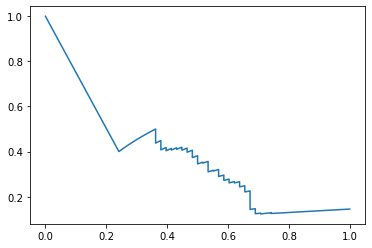

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=4700, loss='deviance', learning_rate=0.28, 
                                    max_features='sqrt', subsample=0.6, max_depth=2, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluate predictions
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['Gradient_Boosting'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

In [29]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import KFold
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(random_state=0)

# model = AdaBoostClassifier(base_estimator=model, random_state=0)

# kfold = KFold(n_splits=3, shuffle=True, random_state=0)

# distributions = dict(n_estimators = list(range(50, 5000, 50)), 
#                      learning_rate = list(np.round(np.arange(0.02, 1, 0.02), 2)), 
#                      algorithm = ['SAMME.R', 'SAMME'])

# rscv = RandomizedSearchCV(estimator=model, param_distributions=distributions, 
#                           cv=kfold, scoring='f1', n_jobs=-1, random_state=0)

# best_score = 0
# best_params = None
# for _ in range(500):
#     search = rscv.fit(X_train, y_train)
#     if search.best_score_ > best_score:
#         best_score = search.best_score_
#         best_params = search.best_params_

# print('best_score', best_score)
# print('best_params', best_params)

accuracy: 0.8775
mcc: 0.36718886798651496
precision: 0.8
recall: 0.20689655172413793
f1_score: 0.3287671232876712
auc_precision_recall:  0.5896954567226846


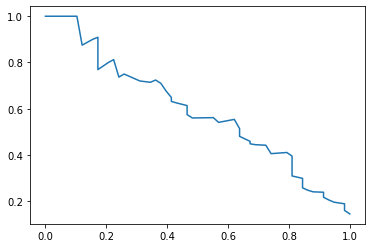

In [30]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)

model = AdaBoostClassifier(base_estimator=model, n_estimators=3000, learning_rate=0.56, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluate predictions
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['AdaBoost_RF'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

In [31]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import KFold
# from sklearn.svm import SVC

# model = SVC(random_state=0, probability=True)

# kfold = KFold(n_splits=3, shuffle=True, random_state=0)

# distributions = dict(C=list(np.round(np.arange(0.1, 1, 0.1), 2)) + list(range(1, 10, 1)) + list(range(10, 110, 10)),
#                      kernel = ['rbf', 'poly', 'sigmoid'],
#                      degree = list(range(1, 11, 1)),
#                      gamma = ['scale', 'auto'],
#                      coef0 = list(np.round(np.arange(0, 1.1, 0.1), 2)), 
#                      decision_function_shape = ['ovo', 'ovr'])

# rscv = RandomizedSearchCV(estimator=model, param_distributions=distributions, 
#                           cv=kfold, scoring='f1', n_jobs=-1, random_state=0)

# best_score = 0
# best_params = None
# for _ in range(100):
#     search = rscv.fit(X_train, y_train)
#     if search.best_score_ > best_score:
#         best_score = search.best_score_
#         best_params = search.best_params_

# print('best_score', best_score)
# print('best_params', best_params)

accuracy: 0.8525
mcc: 0.34773080487926517
precision: 0.4888888888888889
recall: 0.3793103448275862
f1_score: 0.4271844660194175
auc_precision_recall:  0.4569500598793847


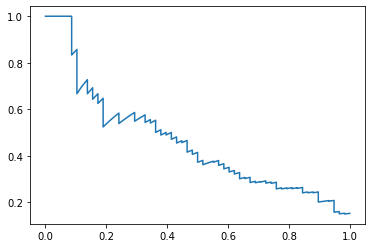

In [32]:
from sklearn.svm import SVC

model = SVC(random_state=0, probability=True, kernel='poly', gamma='scale', degree=8,
            decision_function_shape='ovo', coef0=0.0, C=60)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate predictions
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['SVC'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

accuracy: 0.89
mcc: 0.46124403179646195
precision: 0.8181818181818182
recall: 0.3103448275862069
f1_score: 0.45000000000000007
auc_precision_recall:  0.5976485044751556


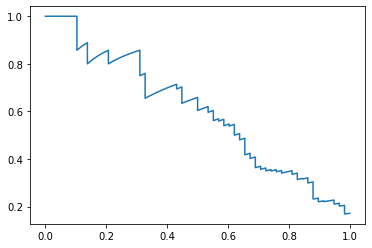

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(random_state=0)
svc = SVC(random_state=0, probability=True)

estimators = [('rf', rf), ('svc', svc)]

model = StackingClassifier(estimators=estimators, final_estimator = svc, passthrough=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['Stacking_RandomForest_SVC'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

In [34]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import KFold
# from sklearn.tree import DecisionTreeClassifier

# model = DecisionTreeClassifier(random_state=0, class_weight='balanced')

# kfold = KFold(n_splits=3, shuffle=True, random_state=0)

# distributions = dict(criterion = ['gini', 'entropy'], min_samples_split = list(range(2, 100, 2)),
#                      max_features = ['sqrt', 'log2'], max_leaf_nodes = list(range(10, 55, 5)) + [None])

# rscv = RandomizedSearchCV(estimator=model, param_distributions=distributions, 
#                           cv=kfold, scoring='f1', n_jobs=-1, random_state=0)

# best_score = 0
# best_params = None
# for _ in range(100):
#     search = rscv.fit(X_train, y_train)
#     if search.best_score_ > best_score:
#         best_score = search.best_score_
#         best_params = search.best_params_

# print('best_score', best_score)
# print('best_params', best_params)

accuracy: 0.71
mcc: 0.2985764477292745
precision: 0.2898550724637681
recall: 0.6896551724137931
f1_score: 0.40816326530612246
auc_precision_recall:  0.31621346842957676


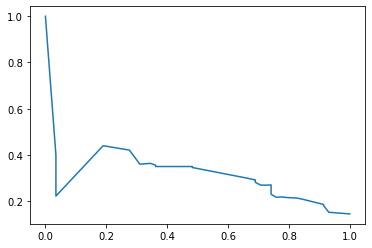

In [35]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0, 
                               class_weight="balanced", 
                               min_samples_split=6,
                               max_leaf_nodes=45,
                               max_features='log2',
                               criterion='gini')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate predictions
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['Decision_Tree_Classifier'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

accuracy: 0.71
mcc: 0.2985764477292745
precision: 0.2898550724637681
recall: 0.6896551724137931
f1_score: 0.40816326530612246
auc_precision_recall:  0.505226067744089


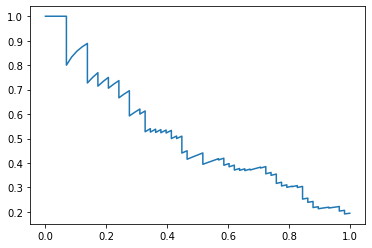

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(tol=0.0001, store_covariance=True, solver='lsqr', shrinkage=0.8)

#fit the model
model.fit(X_train_upsampled, y_train_upsampled)

y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, True], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['LDA'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

/home/gevorg/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


accuracy: 0.71
mcc: 0.2985764477292745
precision: 0.2898550724637681
recall: 0.6896551724137931
f1_score: 0.40816326530612246
auc_precision_recall:  0.5098907366795719


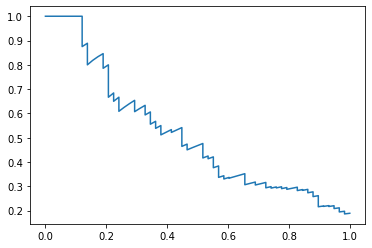

In [37]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model = QuadraticDiscriminantAnalysis(reg_param=0.2, store_covariance=False, tol=0.7)

model.fit(X_train_upsampled, y_train_upsampled)

y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, True], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['QDA'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

accuracy: 0.71
mcc: 0.2985764477292745
precision: 0.2898550724637681
recall: 0.6896551724137931
f1_score: 0.40816326530612246
auc_precision_recall:  0.44684284331890656


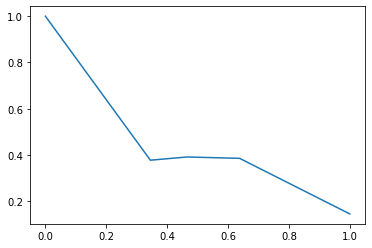

In [38]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3, algorithm='auto', weights ='uniform')

model.fit(X_train_upsampled, y_train_upsampled)

y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, True], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['KNeighbors'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

accuracy: 0.71
mcc: 0.2985764477292745
precision: 0.2898550724637681
recall: 0.6896551724137931
f1_score: 0.40816326530612246
auc_precision_recall:  0.5752723633849047


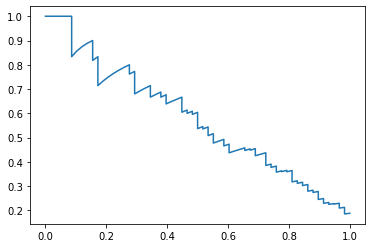

In [39]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=12, max_iter= 1500, penalty= 'l2', tol= 0.0001)

model.fit(X_train_upsampled, y_train_upsampled)

y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, True], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['Logistic Regression'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

accuracy: 0.71
mcc: 0.2985764477292745
precision: 0.2898550724637681
recall: 0.6896551724137931
f1_score: 0.40816326530612246
auc_precision_recall:  0.4585227361122432


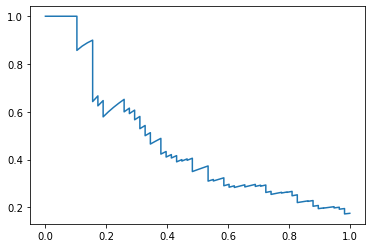

In [40]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=1)

model.fit(X_train_upsampled, y_train_upsampled)

y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, True], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['Multinomial NB'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

accuracy: 0.8825
mcc: 0.4504137619164424
precision: 0.6571428571428571
recall: 0.39655172413793105
f1_score: 0.4946236559139785
auc_precision_recall:  0.5660496972078812


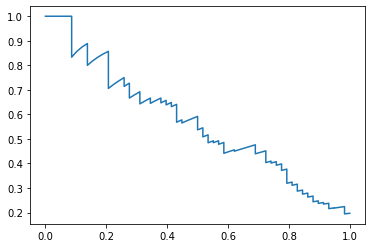

In [41]:
from sklearn.ensemble import AdaBoostClassifier

model = LogisticRegression(C=12, max_iter= 1500, penalty= 'l2', tol= 0.0001)

model = AdaBoostClassifier(base_estimator=model, n_estimators=3000, learning_rate=0.56, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluate predictions
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['AdaBoost_Logistic_Regression'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

In [42]:
# from catboost import CatBoostClassifier

# grid = dict(iterations = list(range(5000, 30500, 500)),
#             learning_rate = list(np.arange(0.1, 1.02, 0.02)),
#             border_count = list(range(50, 100, 2)),
#             rsm = list(np.round(np.arange(0.9, 1, 0.01), 2)),
#             l2_leaf_reg = list(np.round(np.arange(3, 4, 0.1), 2)),
#             one_hot_max_size = list(range(20, 55, 5)), 
#             depth = [2, 3, 4, 5, 6, 7])

# model = CatBoostClassifier(loss_function='CrossEntropy', eval_metric='F1', logging_level='Silent', random_state=0)
# result = model.randomized_search(param_distributions=grid, X=X_train, y=y_train, cv=5, train_size=0.9, n_iter=1000, plot=True)

In [43]:
# result['params']

accuracy: 0.8975
mcc: 0.5216950128793628
precision: 0.7575757575757576
recall: 0.43103448275862066
f1_score: 0.5494505494505494
auc_precision_recall:  0.6125596244777888


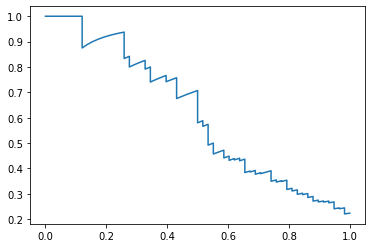

In [44]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=10000, depth=3, learning_rate=0.44, loss_function='CrossEntropy',
                           rsm = 0.9, border_count = 52, eval_metric =  'F1', l2_leaf_reg= 3.5, 
                           one_hot_max_size=30, random_seed = 502, logging_level='Silent')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluate predictions
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['CatBoostClassifier'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

[19:26:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:26:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:26:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:26:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

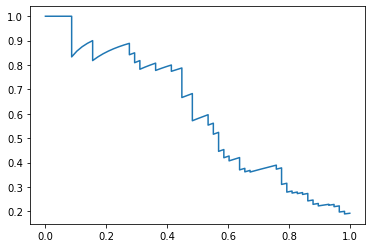

In [45]:
from sklearn.ensemble import StackingClassifier

lr = LogisticRegression(C=12, max_iter= 1500, penalty= 'l2', tol= 0.0001)
xgb = XGBClassifier(use_label_encoder=False)

estimators = [('xgb', xgb), ('lr', lr)]

model = StackingClassifier(estimators=estimators, final_estimator = lr, passthrough=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['Stacking_XGBoost_Logistic_Regression'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

[19:26:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

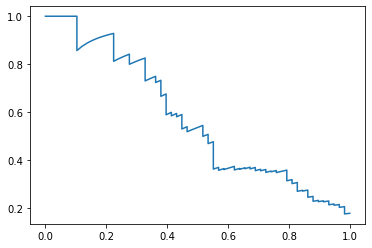

In [46]:
from sklearn.ensemble import StackingClassifier

lr = LogisticRegression(C=12, max_iter= 1500, penalty= 'l2', tol= 0.0001)
xgb = XGBClassifier(use_label_encoder=False)
cb = CatBoostClassifier(logging_level='Silent')
gb = GradientBoostingClassifier(n_estimators=4700, loss='deviance', learning_rate=0.28, 
                                    max_features='sqrt', subsample=0.6, max_depth=2, random_state=0)

estimators = [('xgb', xgb), ('lr', lr), ('cb', cb), ('gb', gb)]

model = StackingClassifier(estimators=estimators, final_estimator = lr, passthrough=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)

mcc = matthews_corrcoef(y_test, y_pred)
print('mcc:', mcc)

precision1 = precision_score(y_test, y_pred)
print('precision:', precision1)

recall1 = recall_score(y_test, y_pred)
print('recall:', recall1)

f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print('auc_precision_recall: ', auc_precision_recall)

metrics = np.array([acc, mcc, precision1, recall1, f1, auc_precision_recall, False], dtype=object).reshape((1,7))
df1 = pd.DataFrame(metrics, index=['Stacking_XGBoost_LogReg_Catboost_GradBoost'], columns=df.columns)
df = pd.concat([df, df1], axis=0)

plt.plot(recall, precision)
plt.show()

In [47]:
df

,accuracy,mcc,precision,recall,f1,auc_precision_recall,Upsampled
XGBoost,0.9,0.532858,0.78125,0.431034,0.555556,0.577641,False
Gradient_Boosting,0.83,0.314378,0.413793,0.413793,0.413793,0.374106,False
AdaBoost_RF,0.8775,0.367189,0.8,0.206897,0.328767,0.589695,False
SVC,0.8525,0.347731,0.488889,0.37931,0.427184,0.45695,False
Stacking_RandomForest_SVC,0.89,0.461244,0.818182,0.310345,0.45,0.597649,False
Decision_Tree_Classifier,0.71,0.298576,0.289855,0.689655,0.408163,0.316213,False
LDA,0.71,0.298576,0.289855,0.689655,0.408163,0.505226,True
QDA,0.71,0.298576,0.289855,0.689655,0.408163,0.509891,True
KNeighbors,0.71,0.298576,0.289855,0.689655,0.408163,0.446843,True
Logistic Regression,0.71,0.298576,0.289855,0.689655,0.408163,0.575272,True


In [48]:
import dataframe_image as dfi

dfi.export(df, 'comparison.png')

In [49]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

lr = LogisticRegression(C=12, max_iter= 1500, penalty= 'l2', tol= 0.0001)
xgb = XGBClassifier(use_label_encoder=False)

estimators = [('xgb', xgb), ('lr', lr)]

model = StackingClassifier(estimators=estimators, final_estimator = lr, passthrough=True)

model.fit(X, y)

fileObj = open('model.obj', 'wb')
pickle.dump(model, fileObj)
fileObj.close()

[19:29:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be